# Multi-Layer Perceptron (MLP) - Model Invariance & Effect of Data Augmentation

An important performance issue of a Multi-Layer Perceptron (MLP) is to consider whether its predictions remain unchanged, or invariant, under one or more transformations of the input data. 

In this recitation, you will implement a solution that ensures invariance of your MLP. 

You will investigate three types of invariance:
- Translation Invariance
- Rotation Invariance
- Noise Invariance


These invariance types are induced in the MLP by training it with an augmented training data. This dataset is created by adding replicas of the training patterns, transformed according to the desired invariances. 

For example:
- For inducing translation invariance, training data is augmented by shifting the image along x-y axes.
- For inducing rotation invariance, training data is augmented by rotating the image.
- For inducing noise invariance, training data is augmented by adding Gaussian noise.

For testing the MLP models you will use a given test data mat file from Canvas. The test data file contains images that are altered by translation/rotation/noise. However, you will not be told what type of transformations are done.

For training the MLP models you will use a given training data mat file from Canvas. The training data file images are not augmented. It contains that images from the MNIST dataset.

From the training dataset, a test subset will be created. This is a non-augmented test subset. Unlike the augmented test set, this test subset does not contain any augmented images.


You will perform the following tasks.
- Task 1: Train a MLP with training data (non-augmented) and evaluate its performance on both the non-augmented and augmented test subsets. [15 points]

- Task 2: Using the augmented test set determine what type of augmentation needs to be done. [20 points]

- Task 3: Augment the training data, [20 points]

- Task 4: Train a MLP model by using the augmented training data and evaluate its performance on both the non-augmented and augmented test subsets. [45 points]


Please complete the marked blocks in this notebook and answer the questions. For training the MLPs use the given setting.

In [1]:
import warnings
import time
import numpy as np
import pandas as pd
import copy 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat

from scipy.ndimage.interpolation import shift, rotate
from scipy.ndimage import gaussian_filter


from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Non-Augmented Data Matrix (X) and the Label Vector (y)


We will use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

There are 70,000 images. Each image is 28x28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has 784 features. 

First load the data from a local folder (obtain it from Canvas) or load it directly from cloud using Scikit-Learn.

In [2]:
# Load the data from the local folder "data"
mnist = loadmat('data/mnist-original.mat')

#Create the data Matrix X and the target vector y
X = mnist["data"].T.astype('float64')
y = mnist["label"][0].astype('int64')

# Load data using Scikit-Learn
# mnist = fetch_openml('mnist_784', cache=False)

# X = mnist["data"].astype('float64')
# y = mnist["target"].astype('int64')


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)

print("\nX type: ", X.dtype)
print("y type: ", y.dtype)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)

X type:  float64
y type:  int64


## Split Data Into Training and Test Sets

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

This function splits arrays or matrices into random train and test subsets.

For the reproducibility of the results, we need to use the same seed for the random number generator. The seed is set by the "random_state" parameter of the split function.

However, in repeated experiments if we don't want to use the same train and test subsets, then we drop the "random_state" parameter from the funtion.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (56000, 784)
X_test:  (14000, 784)


## Data Augmentation

We define the three functions for augmenting the data in the following ways:
- Shifting the image along x-y coordinates (to add translation invariance)
- Rotating the image (to add rotation invariance)
- Blurring the image by adding Gaussian noise (to add noise invariance)


You will use these functions later to augment the training data. Thus, carefully go through the three demos on how to use these three functions.

In [4]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])


def rotate_image(image, angle):
    image = image.reshape((28, 28))
    rotated_image = rotate(image, angle, cval=0, mode="constant", reshape=False)
    return rotated_image.reshape([-1])


def add_gaussian_noise_image(image, sigma):
    image = image.reshape((28, 28))
    gaussian_image = gaussian_filter(image, sigma, cval=0, mode="constant") 
    return gaussian_image.reshape([-1])

## Demo: How to Augment Data by Shifting

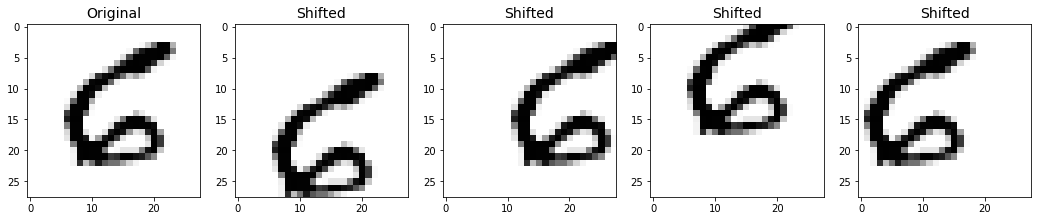

In [5]:
image = X_train[1000]
shifted_image_1 = shift_image(image, 0, 5)
shifted_image_2 = shift_image(image, 5, 0)
shifted_image_3 = shift_image(image, 0, -5)
shifted_image_4 = shift_image(image, -5, 0)


plt.figure(figsize=(18,6))
plt.subplot(151)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(152)
plt.title("Shifted", fontsize=14)
plt.imshow(shifted_image_1.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(153)
plt.title("Shifted", fontsize=14)
plt.imshow(shifted_image_2.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(154)
plt.title("Shifted", fontsize=14)
plt.imshow(shifted_image_3.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(155)
plt.title("Shifted", fontsize=14)
plt.imshow(shifted_image_4.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.show()

# Demo: How to Augment Data by Rotation

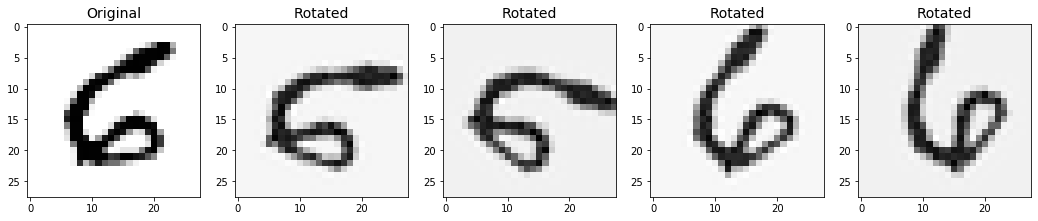

In [6]:
image = X_train[1000]
rotated_image_1 = rotate_image(image, -25)
rotated_image_2 = rotate_image(image, -45)
rotated_image_3 = rotate_image(image, 25)
rotated_image_4 = rotate_image(image, 45)


plt.figure(figsize=(18,6))
plt.subplot(151)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(152)
plt.title("Rotated", fontsize=14)
plt.imshow(rotated_image_1.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(153)
plt.title("Rotated", fontsize=14)
plt.imshow(rotated_image_2.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(154)
plt.title("Rotated", fontsize=14)
plt.imshow(rotated_image_3.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(155)
plt.title("Rotated", fontsize=14)
plt.imshow(rotated_image_4.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

## Demo: How to Augment Data by Blurring

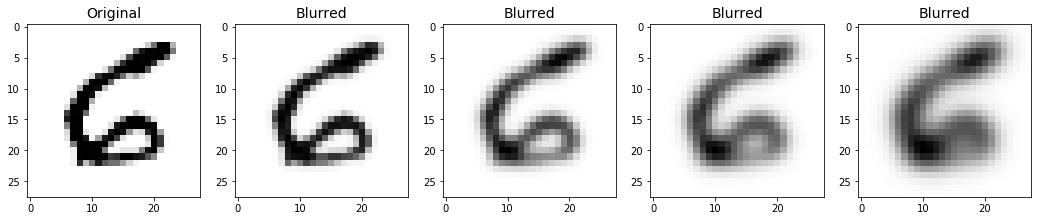

In [7]:
image = X_train[1000]
gaussian_image_1 = add_gaussian_noise_image(image, 0.5)
gaussian_image_2 = add_gaussian_noise_image(image, 1.0)
gaussian_image_3 = add_gaussian_noise_image(image, 1.5)
gaussian_image_4 = add_gaussian_noise_image(image, 2.0)


plt.figure(figsize=(18,6))
plt.subplot(151)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(152)
plt.title("Blurred", fontsize=14)
plt.imshow(gaussian_image_1.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(153)
plt.title("Blurred", fontsize=14)
plt.imshow(gaussian_image_2.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(154)
plt.title("Blurred", fontsize=14)
plt.imshow(gaussian_image_3.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(155)
plt.title("Blurred", fontsize=14)
plt.imshow(gaussian_image_4.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

## Load Augmented Test Data 

Load the following augmented test data file: Test_Data

In [8]:
augmented_test_data = loadmat('data/Test_Data.mat')

X_test_augmented = augmented_test_data["X_test"].astype('float64')
y_test_augmented = augmented_test_data["y_test"][0].astype('int64')

## Scale the Data

In [9]:
# Create a deep copy of the training data for using it later for augmentation
X_train_original = copy.deepcopy(X_train)


X_train /= 255.0
X_test /= 255.0
X_test_augmented /= 255.0

## Task 1: Train a MLP Model using Non-Augmened Training Data [5 points]

In [10]:
%%time
mlp_clf = MLPClassifier(hidden_layer_sizes=(200,), max_iter=200, alpha=0.01,
                    solver='adam', verbose=True, tol=1e-5, random_state=1, 
                    learning_rate='constant', learning_rate_init=0.001, activation='relu',
                    early_stopping=True, n_iter_no_change=10)


# Train the model using the non-augmented training data

# TODO
mlp_clf.fit(X_train, y_train)

Iteration 1, loss = 0.40886675
Validation score: 0.932679
Iteration 2, loss = 0.19419106
Validation score: 0.951429
Iteration 3, loss = 0.14385625
Validation score: 0.960000
Iteration 4, loss = 0.11466252
Validation score: 0.964464
Iteration 5, loss = 0.09499003
Validation score: 0.965714
Iteration 6, loss = 0.08248333
Validation score: 0.970357
Iteration 7, loss = 0.07131126
Validation score: 0.970179
Iteration 8, loss = 0.06324839
Validation score: 0.972500
Iteration 9, loss = 0.05644300
Validation score: 0.973929
Iteration 10, loss = 0.05160096
Validation score: 0.973571
Iteration 11, loss = 0.04799070
Validation score: 0.975179
Iteration 12, loss = 0.04425474
Validation score: 0.976786
Iteration 13, loss = 0.04104076
Validation score: 0.975893
Iteration 14, loss = 0.03763602
Validation score: 0.976786
Iteration 15, loss = 0.03603052
Validation score: 0.977321
Iteration 16, loss = 0.03457569
Validation score: 0.976786
Iteration 17, loss = 0.03249957
Validation score: 0.977143
Iterat

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(200,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=1e-05,
              validation_fraction=0.1, verbose=True, warm_start=False)

## Task 1: Evaluate the Model using Test Data (Non-Augmented & Augmented) [5 points]

Show the training accuracy, test (non-augmented) accuracy and test (augmented) accuracy. 

In [11]:
# TODO
y_train_pred_naug = mlp_clf.predict(X_train)
accu_train_naug = np.mean(y_train == y_train_pred_naug)
print("\nTraining Accuracy (non-augmented): ", accu_train_naug)


# TODO

y_test_pred_naug = mlp_clf.predict(X_test)
accu_test_naug = np.mean(y_test == y_test_pred_naug)
print("\nNon-Augmented Test Accuracy (based on non-augmented model): ", accu_test_naug)



# TODO

y_test_pred_aug = mlp_clf.predict(X_test_augmented)
accu_test_aug = np.mean(y_test_augmented == y_test_pred_aug)
print("\nAugmented Test Accuracy (based on non-augmented model): ", accu_test_aug)


Training Accuracy (non-augmented):  0.9981428571428571

Non-Augmented Test Accuracy (based on non-augmented model):  0.9808571428571429

Augmented Test Accuracy (based on non-augmented model):  0.4307142857142857


## Question [5 points]: 

The augmented test data accuracy should be much smaller than the accuracy of the original (non-augmented) test data. 

- Explain why is the augmented test accuracy low?

Answer: The MLP is not invariant to the translation of the images that are used for training.


## Task 2: Detemine the Type of Data Augmentation [10 points]


You need to analyze the augmented test data (X_test_augmented) to determine what type of augmentation is required for the training data. You may want to visualize a sequence of images (from X_test_augmented) to understand the type of required data augmentation. Please show your work.

For example, if you observe that images are blurred (in X_test_augmented), then augment the training data by adding Gaussian noises. 


As an illustration of how to augment the training data, carefully go through the following block. It shows how to augment the training data by blurring the images. You need to edit the code according to the required data augmentation technique (shifting/rotation/blurring) that you want to apply.


Depending on the augmentation technique, you need to determine the following parameter values for the augmentation function as well:
- Shifting: dx & dy
- Rotation: angle
- Blurring: sigma

Use at least four values for each parameter to augment the data.

CPU times: user 784 ms, sys: 14.4 ms, total: 798 ms
Wall time: 332 ms


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


'\nAnalysis of the augmented test data (X_test_augmented) \n to determine what type of augmentation required for the training data\n'

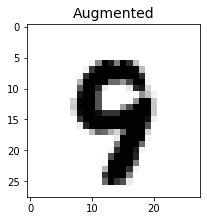

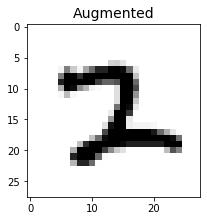

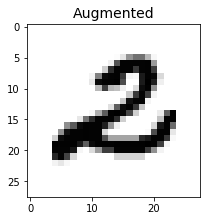

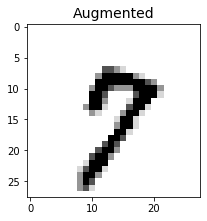

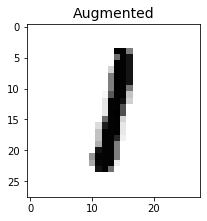

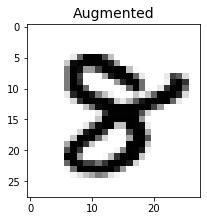

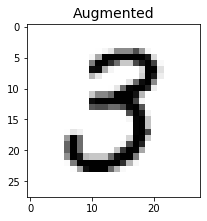

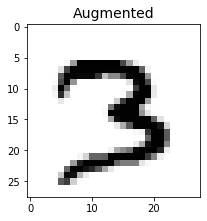

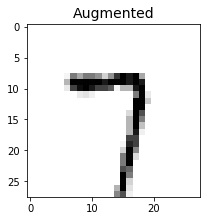

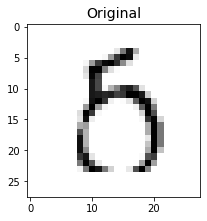

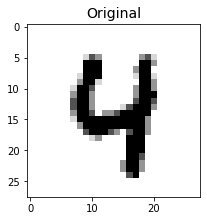

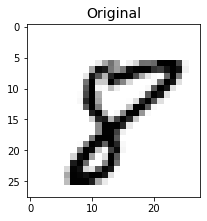

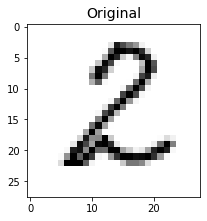

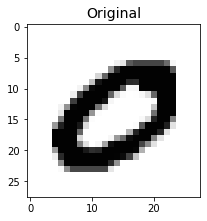

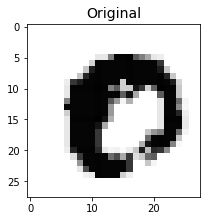

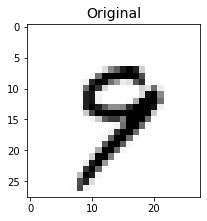

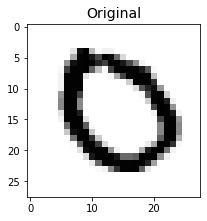

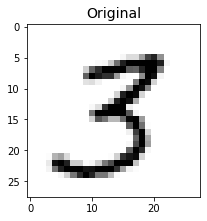

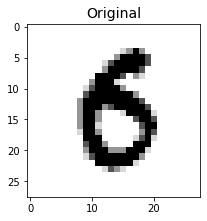

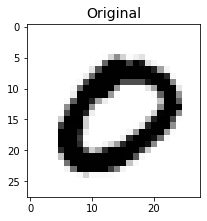

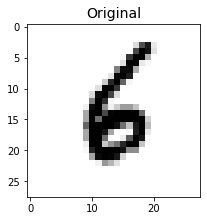

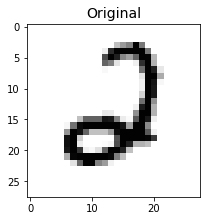

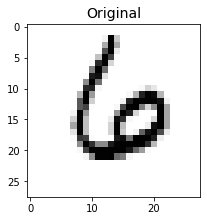

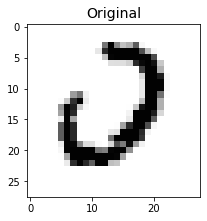

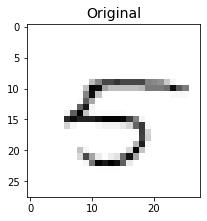

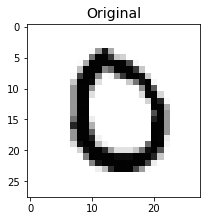

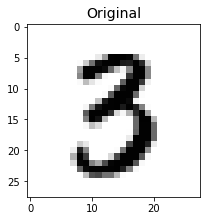

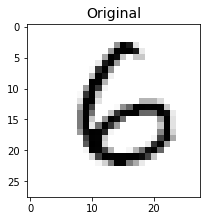

In [12]:
%%time
# TODO 
for i in X_test_augmented[1:10, :]: 
    plt.figure(figsize=(18,6))
    plt.subplot(151)
    plt.title("Augmented", fontsize=14)
    plt.imshow(i.reshape(28, 28), interpolation="nearest", cmap="Greys")

for i in X_train_original[1:20, :]:
    plt.figure(figsize=(18,6))
    plt.subplot(151)
    plt.title("Original", fontsize=14)
    plt.imshow(i.reshape(28, 28), interpolation="nearest", cmap="Greys")
'''
Analysis of the augmented test data (X_test_augmented) 
 to determine what type of augmentation required for the training data
'''

Question 1 [5 points]: What data augmentation would you like to perform? Justify?

- Answer: The data would be rotated. Through printing out some of the augmented data as pictures I found some of them are tilted somewhat.



Question 2 [5 points]: What are the four values that you plan to use for the parameter of the augmentation function?

- Answer: I would rotate the images by unit: 45, 90, 135, 180.
              

## Task 3: Augment the Training Data [20 points]

In [13]:
%%time

X_train_augmented = [image for image in X_train_original ]
y_train_augmented = [label for label in y_train]


# TODO
# Edit the following code block to implement appropriate augmentation
#for dx, dy in ((3, 0), (-3, 0), (0, 3), (0, 4), (0, -3), (0, -4), (0, -5), (0, -6), (0, -7)):
#    for image, label in zip(X_train_original, y_train):
#        X_train_augmented.append(shift_image(image, dx, dy))
#        y_train_augmented.append(label)
        
        
for rt in (45, 90, 135, 180):
    for image, label in zip(X_train_original, y_train):
        X_train_augmented.append(rotate_image(image, rt))
        y_train_augmented.append(label)

        
# Augmentation by blurring
#for sigma in (0.5, 1.0, 1.5, 2.0):
#    for image, label in zip(X_train_original, y_train):
#        X_train_augmented.append(add_gaussian_noise_image(image, sigma))
#        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

print("X_train_augmented Shape: ", X_train_augmented.shape)

X_train_augmented Shape:  (280000, 784)
CPU times: user 42.3 s, sys: 2.31 s, total: 44.6 s
Wall time: 45 s


## Randomize the Augmented Data

In [14]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

## Scale the Augmented Training Data

In [15]:
X_train_augmented /= 255.0

## Task 4: Train a MLP Model using Augmened Training Data

In [16]:
%%time
mlp_clf_aug = MLPClassifier(hidden_layer_sizes=(200,), max_iter=200, alpha=0.01,
                    solver='adam', verbose=True, tol=1e-5, random_state=1, 
                    learning_rate='constant', learning_rate_init=0.001, activation='relu',
                    early_stopping=True, n_iter_no_change=10)


# Train the model using the augmented training data

# TODO
mlp_clf_aug.fit(X_train_augmented, y_train_augmented)

Iteration 1, loss = 0.50224294
Validation score: 0.918036
Iteration 2, loss = 0.24971122
Validation score: 0.936964
Iteration 3, loss = 0.20192995
Validation score: 0.944786
Iteration 4, loss = 0.17825386
Validation score: 0.950214
Iteration 5, loss = 0.16404057
Validation score: 0.950929
Iteration 6, loss = 0.15394827
Validation score: 0.953179
Iteration 7, loss = 0.14691273
Validation score: 0.953357
Iteration 8, loss = 0.13998894
Validation score: 0.955571
Iteration 9, loss = 0.13575104
Validation score: 0.954857
Iteration 10, loss = 0.13162668
Validation score: 0.957179
Iteration 11, loss = 0.12758550
Validation score: 0.956857
Iteration 12, loss = 0.12371897
Validation score: 0.956214
Iteration 13, loss = 0.12252429
Validation score: 0.956071
Iteration 14, loss = 0.11924956
Validation score: 0.954071
Iteration 15, loss = 0.11748981
Validation score: 0.956357
Iteration 16, loss = 0.11460634
Validation score: 0.957036
Iteration 17, loss = 0.11385131
Validation score: 0.956929
Iterat

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(200,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='adam', tol=1e-05,
              validation_fraction=0.1, verbose=True, warm_start=False)

## Task 4: Evaluate the Model using Test Data (Non-Augmented & Augmented) [20 points]

Show the training accuracy, test (non-augmented) accuracy and test (augmented) accuracy. 

In [17]:
# TODO
y_train_pred_aug = mlp_clf_aug.predict(X_train_augmented)
accu_train_aug = np.mean(y_train_augmented == y_train_pred_aug)
print("\nTraining Accuracy (based on augmented model): ",  accu_train_aug)


# TODO
y_test_pred_naug_based_on_aug = mlp_clf_aug.predict(X_test)
accu_test_aug_based_on_naug = np.mean(y_test == y_test_pred_naug_based_on_aug)
print("\nNon-Augmented Test Accuracy (based on augmented model): ", accu_test_aug_based_on_naug)



# TODO
y_test_pred_aug_based_on_aug = mlp_clf_aug.predict(X_test_augmented)
accu_test_aug_based_on_aug = np.mean(y_test_augmented == y_test_pred_aug_based_on_aug)
print("\nAugmented Test Accuracy (based on augmented model): ", accu_test_aug_based_on_aug)


Training Accuracy (based on augmented model):  0.9852714285714286

Non-Augmented Test Accuracy (based on augmented model):  0.9575

Augmented Test Accuracy (based on augmented model):  0.9597428571428571


## Report Your Observation [25 points]

Using a table report the effect of the data augmentation on the models performance.

In [18]:

print("\nAugmented Test Accuracy (based on non-augmented model): ", accu_test_aug)

print("\nAugmented Test Accuracy (based on augmented model): ", accu_test_aug_based_on_aug)


Augmented Test Accuracy (based on non-augmented model):  0.4307142857142857

Augmented Test Accuracy (based on augmented model):  0.9597428571428571


In [21]:
d = [['Non-augmented', accu_train_naug, accu_test_aug, X_train.shape, '1min 27s'],
    ['Augmented', accu_train_aug, accu_test_aug_based_on_aug, X_train_augmented.shape, '7min 16s']]
pd.DataFrame(d, columns=['Data Form' ,'Train Accuracy', 'Test Accuracy', 'Train Size', 'Training Time'])

,Data Form,Train Accuracy,Test Accuracy,Train Size,Training Time
0,Non-augmented,0.998143,0.430714,"(56000, 784)",1min 27s
1,Augmented,0.985271,0.959743,"(280000, 784)",7min 16s
